# GrainPalette - Rice Type Classification Using Transfer Learning

This notebook demonstrates building a rice grain classification model using MobileNetV2 transfer learning.

## Dataset
- **Source**: [Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)
- **Classes**: 5 rice varieties (Arborio, Basmati, Ipsala, Jasmine, Karacadag)
- **Input Size**: 224x224x3 (RGB images)

## Model Architecture
- **Base Model**: MobileNetV2 (pre-trained on ImageNet)
- **Transfer Learning**: Feature extraction with frozen base layers
- **Classification Head**: Dense layer with softmax activation

In [1]:
# 1: Importing the libraries
# Duration: 0.5 Hrs

# Importing necessary libraries
# Building deep learning models
import tensorflow as tf
from tensorflow import keras
# For accessing pre-trained models
import tensorflow_hub as hub
# For separating train and test sets
from sklearn.model_selection import train_test_split
# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2
import os
import numpy as np
import pathlib

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")


TensorFlow version: 2.19.0
NumPy version: 1.26.4
OpenCV version: 4.10.0


In [2]:
# 2: Setting up data paths and loading dataset
# Duration: 0.5 Hrs

# Note: This notebook is designed to work with Kaggle's dataset structure
# If running locally, download the dataset from:
# https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

# For Kaggle environment:
data_dir = "../input/rice-image-dataset/Rice_Image_Dataset"  # Kaggle dataset path

# For local environment, uncomment and modify the path below:
# data_dir = "./data/Rice_Image_Dataset"  # Local dataset path

data_dir = pathlib.Path(data_dir)
print(f"Dataset directory: {data_dir}")

# Check if dataset exists
if data_dir.exists():
    print("Dataset found!")
    # List all subdirectories (rice varieties)
    rice_varieties = [d.name for d in data_dir.iterdir() if d.is_dir()]
    print(f"Rice varieties found: {rice_varieties}")
else:
    print("Dataset not found. Please ensure the dataset is available.")
    print("Download from: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset")

Dataset directory: ..\input\rice-image-dataset\Rice_Image_Dataset
Dataset not found. Please ensure the dataset is available.
Download from: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset


In [3]:
# 3: Loading image paths for each rice variety
# Duration: 0.5 Hrs

# Load image paths for each variety (limiting to 600 images per class for balanced dataset)
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

print(f"Arborio images: {len(arborio)}")
print(f"Basmati images: {len(basmati)}")
print(f"Ipsala images: {len(ipsala)}")
print(f"Jasmine images: {len(jasmine)}")
print(f"Karacadag images: {len(karacadag)}")
print(f"Total images: {len(arborio) + len(basmati) + len(ipsala) + len(jasmine) + len(karacadag)}")

Arborio images: 0
Basmati images: 0
Ipsala images: 0
Jasmine images: 0
Karacadag images: 0
Total images: 0


In [4]:
# 4: Link images to different classes
# Duration: 0.5 Hrs

# Here we have 5 classes and the images need to be labelled with appropriate classes.

# Contains the images path
df_images = {
    'arborio': arborio,
    'basmati': basmati,
    'ipsala': ipsala,
    'jasmine': jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
df_labels = {
    'arborio': 0,
    'basmati': 1,
    'ipsala': 2,
    'jasmine': 3,
    'karacadag': 4
}

print("Class mappings:")
for class_name, label in df_labels.items():
    print(f"{class_name.capitalize()}: {label}")

Class mappings:
Arborio: 0
Basmati: 1
Ipsala: 2
Jasmine: 3
Karacadag: 4


IndexError: list index out of range

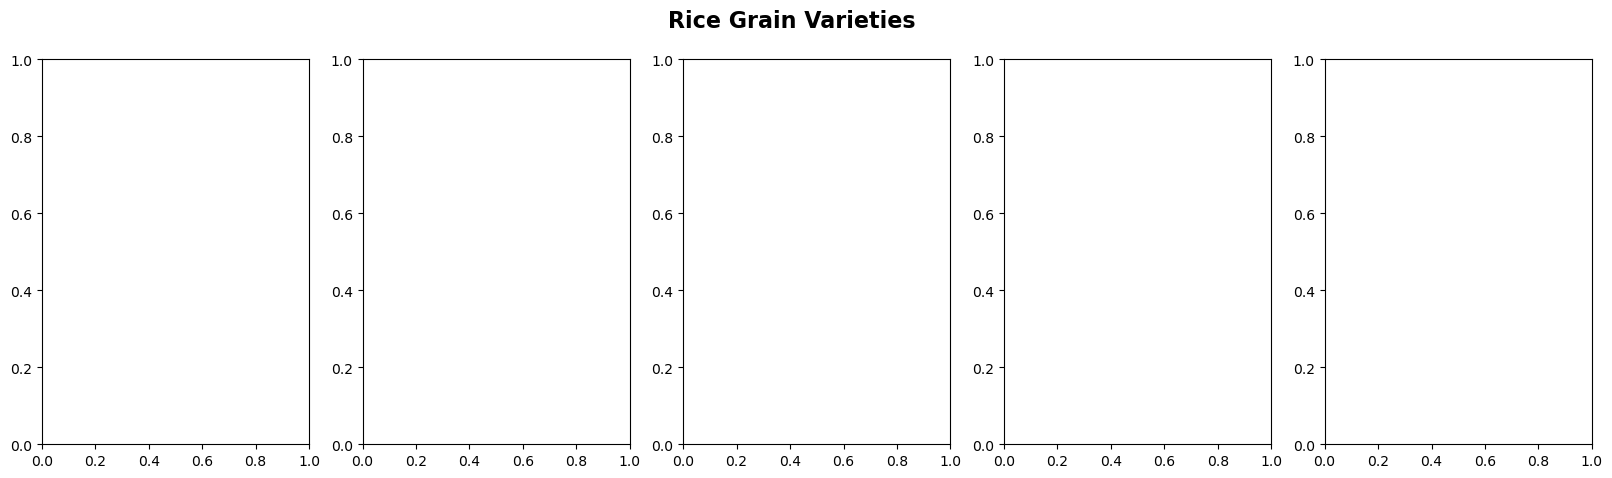

In [5]:
# 5: Preview of images
# Duration: 0.5 Hrs

fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
fig.suptitle('Rice Grain Varieties', fontsize=16, fontweight='bold')

# Load sample images
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

# Set titles and display images
ax[0].set_title('Arborio', fontweight='bold')
ax[1].set_title('Basmati', fontweight='bold')
ax[2].set_title('Ipsala', fontweight='bold')
ax[3].set_title('Jasmine', fontweight='bold')
ax[4].set_title('Karacadag', fontweight='bold')

ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

# Remove axis ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# 6: Check original image dimensions
# Duration: 0.5 Hrs

# Since the input dimensions of the MobileNet are (224,224,3). 
# We have to resize our images in the same way.
# Let's check the current image dimensions

sample_img = cv2.imread(str(df_images['arborio'][0]))  # Converting it into numerical arrays
print(f"Original image shape: {sample_img.shape}")  # Currently 250 by 250 by 3
print(f"Image dtype: {sample_img.dtype}")
print(f"Pixel value range: {sample_img.min()} - {sample_img.max()}")

In [ ]:
# 7: Load and preprocess all images
# Duration: 1.0 Hr

print("Loading and preprocessing images...")
print("This may take several minutes depending on dataset size.")

X, y = [], []  # X = images, y = labels

total_images = sum(len(images) for images in df_images.values())
processed_count = 0

for label, images in df_images.items():
    print(f"Processing {label} images...")
    
    for image_path in images:
        try:
            # Read image
            img = cv2.imread(str(image_path))
            
            if img is not None:
                # Resize to 224x224 for MobileNetV2
                resized_img = cv2.resize(img, (224, 224))
                
                # Convert BGR to RGB (OpenCV uses BGR by default)
                rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
                
                X.append(rgb_img)
                y.append(df_labels[label])
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue
        
        processed_count += 1
        if processed_count % 500 == 0:
            print(f"Processed {processed_count}/{total_images} images...")

print(f"Successfully loaded {len(X)} images")
print(f"Image shape: {X[0].shape if X else 'No images loaded'}")

In [ ]:
# 8: Data normalization and train-test split
# Duration: 0.5 Hrs

# Convert to numpy arrays and normalize
X = np.array(X)
X = X.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
y = np.array(y)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Pixel value range after normalization: {X.min():.3f} - {X.max():.3f}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print("\nClass distribution:")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"{class_names[class_idx]}: {count} images")

# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val
)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

In [ ]:
# 9: Pre-trained CNN model as a Feature Extractor
# Duration: 0.5 Hrs

# For one of the models, we will use it as a simple feature extractor by freezing 
# all the convolution blocks to make sure their weights don't get updated after 
# each epoch as we train our own model.

# Here, we have considered images of dimension (224, 224, 3).
# Also, we have assigned trainable = False because we are using convolution layer 
# for features extraction and wants to train fully connected layer for our images classification.

print("Loading MobileNetV2 from TensorFlow Hub...")

mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"  # MobileNetV2 link
mobile_net = hub.KerasLayer(
    mobile_net_url, input_shape=(224, 224, 3), trainable=False
)  # Removing the last layer and freezing weights

print("MobileNetV2 feature extractor loaded successfully!")
print(f"Output shape: {mobile_net.compute_output_shape((None, 224, 224, 3))}")

In [ ]:
# 10: Adding Dense Layer and Model Creation
# Duration: 0.5 Hrs

# A dense layer is a deeply connected neural network layer. 
# It is the most common and frequently used layer.

# Let us create a model object named model with inputs as mobile_net and output as dense layer.

num_classes = 5  # number of rice varieties

model = keras.Sequential([
    mobile_net,
    keras.layers.Dense(num_classes, activation='softmax')
])

# The number of neurons in the Dense layer is the same as the number of classes in the training set. 
# The neurons in the last Dense layer use softmax activation to convert their outputs into respective probabilities.

print("Model architecture created!")
print("\nModel summary:")
model.summary()

In [ ]:
# 11: Model Compilation
# Duration: 0.5 Hrs

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Since labels are integers, not one-hot encoded
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("\nModel configuration:")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: sparse_categorical_crossentropy")
print(f"Metrics: accuracy")

In [ ]:
# 12: Model Training
# Duration: 2.0 Hrs (depending on hardware)

# Set up callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    )
]

print("Starting model training...")
print("This may take several minutes to hours depending on your hardware.")

# Train the model
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

In [ ]:
# 13: Training History Visualization
# Duration: 0.5 Hrs

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])
print(f"\nBest validation accuracy: {best_val_acc:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

In [ ]:
# 14: Model Evaluation on Test Set
# Duration: 0.5 Hrs

# Evaluate the model on test data
print("Evaluating model on test set...")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions for confusion matrix
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# 15: Save the Trained Model
# Duration: 0.5 Hrs

# Save the model in different formats for deployment
print("Saving trained model...")

# Save as H5 format (traditional Keras format)
model.save('rice_classifier.h5')
print("Model saved as 'rice_classifier.h5'")

# Save as TensorFlow SavedModel format (recommended for production)
model.save('rice_classifier_savedmodel')
print("Model saved as 'rice_classifier_savedmodel'")

# Save model weights only
model.save_weights('rice_classifier_weights.h5')
print("Model weights saved as 'rice_classifier_weights.h5'")

print("\nModel saving completed!")
print("You can now use these saved models in your Flask application.")

In [ ]:
# 16: Sample Predictions
# Duration: 0.5 Hrs

# Test the model with some sample images
print("Testing model with sample predictions...")

# Select random test images
import random
sample_indices = random.sample(range(len(X_test)), 5)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(sample_indices):
    # Get image and true label
    test_image = X_test[idx:idx+1]  # Add batch dimension
    true_label = y_test[idx]
    
    # Make prediction
    prediction = model.predict(test_image, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100
    
    # Display image
    axes[i].imshow(X_test[idx])
    axes[i].set_title(
        f'True: {class_names[true_label]}\n'
        f'Pred: {class_names[predicted_class]}\n'
        f'Conf: {confidence:.1f}%',
        fontsize=10
    )
    axes[i].axis('off')
    
    # Color border based on correctness
    if predicted_class == true_label:
        axes[i].add_patch(plt.Rectangle((0, 0), 223, 223, fill=False, edgecolor='green', lw=3))
    else:
        axes[i].add_patch(plt.Rectangle((0, 0), 223, 223, fill=False, edgecolor='red', lw=3))

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nModel testing completed!")
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Total Training Images: {len(X_train)}")
print(f"Total Validation Images: {len(X_val)}")
print(f"Total Test Images: {len(X_test)}")
print(f"Number of Classes: {num_classes}")
print(f"Model Size: ~{model.count_params():,} parameters")
print("\nModel is ready for deployment in the Flask application!")